In [2]:
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1 MB 1.5 MB/s eta 0:13:11tcmalloc: large alloc 1147494400 bytes == 0x3a834000 @  0x7f296a581615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████               | 1055.7 MB 1.2 MB/s eta 0:12:24tcmalloc: large alloc 1434370048 bytes == 0x7ee8a000 @  0x7f296a581615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████

In [3]:
!pip install torchtext==0.9

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.1 MB 5.1 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0


In [1]:
import time
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy import data, datasets
from tqdm import tqdm

SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [2]:
!nvidia-smi

Mon Jun 13 20:52:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
TEXT = data.Field(tokenize = 'spacy', include_lengths = True)
LABEL = data.LabelField(dtype = torch.float)

In [4]:
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

In [5]:
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [6]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE)

LABEL.build_vocab(train_data)

In [7]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

In [8]:
class LSTMAttention(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, output_dim, n_layers, 
                 dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.n_layers = n_layers
        self.pad_idx = pad_idx
        self.rnn = nn.LSTM(emb_dim, hidden_dim, num_layers=n_layers, bidirectional=True,
                           dropout=dropout)
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.attn = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.v = nn.Linear(hidden_dim*2, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def create_mask(self, src):
        # src: [src_len, batch_size]
        mask = (src != self.pad_idx)
        mask = mask.permute(1, 0)
        
        # mask: [batch_size, src_len]
        return mask

    def attention(self, hidden, outputs, mask):
        # hidden: [batch_size, hidden_dim * 2]
        # outputs: [seq_len, batch_size, hidden_dim * 2]
        # mask: [batch_size, src_len]

        batch_size = outputs.shape[1]
        seq_len = outputs.shape[0]

        # hidden: [batch_size, seq_len, hidden_dim * 2]
        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        
        # outputs: [batch_size, seq_len, hidden_dim * 2]
        outputs = outputs.permute(1, 0, 2)

        # energy: [batch_size, seq_len, hidden_dim * 2]
        energy = torch.tanh(self.attn(torch.cat((hidden, outputs), dim=2)))
        attention_energy = self.v(energy).squeeze(2)

        # attention_energy: [batch_size, seq_len]
        attention_energy = attention_energy.masked_fill(mask == 0, -1e10)

        return F.softmax(attention_energy, dim=1)

    def forward(self, src, src_lengths):
        batch_size = src.shape[1]
        mask = self.create_mask(src)

        embedded = self.dropout(self.embedding(src))

        packed_input = nn.utils.rnn.pack_padded_sequence(embedded, src_lengths)
        packed_outputs, (hidden, _) = self.rnn(packed_input)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)

        # outputs: [seq_len, batch_size, hid_dim * 2]
        # hidden: [num_layers * num_directions, batch_size, hidden_dim]

        hidden = hidden.view(self.n_layers, 2, batch_size, -1)

        # concat final forward and backward hidden states
        hidden = torch.cat((hidden[-1][0][:], hidden[-1][1][:]), dim=1)
        hidden = self.dropout(hidden)

        attention_energies = self.attention(hidden, outputs, mask)

        attention_energies = attention_energies.unsqueeze(1)

        outputs = outputs.permute(1, 0, 2)

        # attention_energies: [batch_size, 1, seq_len]
        # outputs: [batch_size, seq_len, hidden_dim * 2]

        # weighted: [batch_size, 1, hidden_dim * 2]
        weighted = torch.bmm(attention_energies, outputs)

        # weighted: [batch_size, hidden_dim * 2]
        weighted = weighted.squeeze(1)

        logits = self.fc(weighted)
        # logits: [batch_size, output_dim]
        return logits, attention_energies.squeeze(1)

        

In [9]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = LSTMAttention(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT, PAD_IDX).to(device)

In [10]:
print(model)

LSTMAttention(
  (embedding): Embedding(25002, 100)
  (rnn): LSTM(100, 256, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (attn): Linear(in_features=1024, out_features=512, bias=True)
  (v): Linear(in_features=512, out_features=1, bias=False)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [11]:
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [12]:
def binary_accuracy(preds, y):
    predicted = torch.round(torch.sigmoid(preds))
    correct = (predicted == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [13]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    
    for batch in iterator:
        optimizer.zero_grad()

        input, input_lengths = batch.text
        preds, _ = model(input, input_lengths.to('cpu'))
        preds = preds.squeeze(1)


        loss = criterion(preds, batch.label)
        acc = binary_accuracy(preds, batch.label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [17]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    
    for batch in iterator:
        input, input_lengths = batch.text
        preds, _ = model(input, input_lengths.to('cpu'))
        preds = preds.squeeze(1)   
        loss = criterion(preds, batch.label)
        acc = binary_accuracy(preds, batch.label)

        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [18]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [19]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()
    # torch.cuda.empty_cache()
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'lstm-attention.pt')
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

model.load_state_dict(torch.load('lstm-attention.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 47s
	Train Loss: 0.432 | Train Acc: 80.41%
	 Val. Loss: 0.397 |  Val. Acc: 83.21%
Epoch: 02 | Epoch Time: 0m 49s
	Train Loss: 0.353 | Train Acc: 84.86%
	 Val. Loss: 0.329 |  Val. Acc: 85.72%
Epoch: 03 | Epoch Time: 0m 48s
	Train Loss: 0.305 | Train Acc: 87.40%
	 Val. Loss: 0.281 |  Val. Acc: 88.84%
Epoch: 04 | Epoch Time: 0m 49s
	Train Loss: 0.261 | Train Acc: 89.54%
	 Val. Loss: 0.289 |  Val. Acc: 89.21%
Epoch: 05 | Epoch Time: 0m 48s
	Train Loss: 0.242 | Train Acc: 90.54%
	 Val. Loss: 0.265 |  Val. Acc: 89.86%
Test Loss: 0.285 | Test Acc: 88.75%


In [20]:
import spacy

In [120]:
nlp = spacy.load('en')

def inference(model, sentence):
    model.eval()
    if isinstance(sentence, str):
        tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    else:
        tokenized = sentence
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length).to('cpu')
    with torch.no_grad():
        logits, attention = model(tensor, length_tensor)
    print(logits)
    prediction = torch.sigmoid(logits)
    if prediction.item() < 0.5:
        sentiment = "Positive"
    elif prediction.item() > 0.5:
        sentiment = "Negative"
    elif prediction.item() == 0.0:
        sentiment = "Neutral"
    return tokenized, sentiment, prediction.item(), attention.squeeze()

In [121]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [122]:
def display_attention(labels, attention):
    attention = attention.cpu().detach().numpy()
    attention = np.around(attention, 4)
    fig, ax = plt.subplots(figsize=(len(labels),15))
    im = ax.imshow([attention])
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels("")
    # ax = sns.heatmap([attention], vmin=0, vmax=1, annot=True, xticklabels=labels, yticklabels=False)
    for i in range(len(labels)):
        text = ax.text(i, 0, attention[i], ha="center", va="center", color="w")
    plt.show()
    plt.close()

In [123]:
review = "The movie was absolutely unwatchable"

tensor([[11.9015]], device='cuda:0')
Review: The movie was absolutely unwatchable
predicted sentiment: Negative with probability score of 1.000


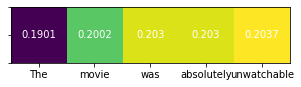

In [124]:
tokens, sentiment, predicted, attention = inference(model, review)
print(f"Review: {review}")
print(f"predicted sentiment: {sentiment} with probability score of {predicted:.3f}")
display_attention(tokens, attention)